## Adi-reader

### V1

In [1]:
import adi
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#path = r'..\uploaded_files\archivo_de_prueba.adicht' # Cambiar la ruta al archivo
path = r"..\uploaded_files\AFT_20240816_170-JV.adicht"  # Cambiar la ruta al archivo
path2 = r".\TESTPD 20250127.adicht"  

f = adi.read_file(path)
f

file_loaded: True
          h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
  n_records: 1
 n_channels: 14
    records: Type::list, Len: 1
   channels: Type::list, Len: 14

In [3]:
for ch in f.channels:
    n_samples = sum(ch.n_samples)
    fs_ch = ch.fs[0]
    print(f"{ch.name.strip()}: n_samples/fs = {n_samples/fs_ch:.2f} s para {n_samples} muestras a {fs_ch} Hz")

BioAmp raw: n_samples/fs = 7261.60 s para 72616000 muestras a 10000.0 Hz
HR: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
ECG: n_samples/fs = 7261.60 s para 7261600 muestras a 1000.0 Hz
FBP: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
Valsalva: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
CO: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
SV: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
SVR: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
ETCO2: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
SPO2: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
MCA-L: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
MCA-R: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
Tilt Angle: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz
MAP: n_samples/fs = 7261.60 s para 726160 muestras a 100.0 Hz


In [4]:
for i in range(f.n_channels):
    print(f.channels[i].name)
    

BioAmp raw
HR
ECG
FBP
Valsalva
CO
SV
SVR
ETCO2
SPO2
MCA-L
MCA-R
Tilt Angle
MAP


In [4]:
f = adi.read_file(path)
channel_names = [ch.name.strip() for ch in f.channels][1:]
print(channel_names)

channel_data = []
for ch in f.channels[1:]:
    for r in range(ch.n_records):
        ch.get_data(r+1)

['HR', 'ECG', 'FBP', 'Valsalva', 'CO', 'SV', 'SVR', 'ETCO2', 'SPO2', 'MCA-L', 'MCA-R', 'Tilt Angle', 'MAP']


In [6]:
# Leer archivo solo si es necesario (ya está cargado en 'f' y 'path')
# Obtener nombres de canales (excepto el primero)

channel_names = [ch.name.strip() for ch in f.channels][1:]

channel_data = []
max_len = 0
fs = 1000

# Concatenar todos los records de cada canal y calcular longitud máxima

for ch in f.channels[:]:
    data_segments = []
    for i in range(ch.n_records):
        try:
            data_segments.append(ch.get_data(i+1))
        except Exception as e:
            print(f"Warning: Could not retrieve data for channel '{ch.name.strip()}', record {i}: {e}")
            
    if data_segments:
        data = np.concatenate(data_segments)
        channel_data.append(data)

        if len(data) > max_len:
            max_len = len(data)
        if fs is None:
            fs = ch.fs[0]
    else:
        channel_data.append(np.array([]))

# Rellenar con NaN para igualar longitudes
channel_data_padded = [
    np.pad(data, (0, max_len - len(data)), constant_values=np.nan)
    for data in channel_data
]

# Generar columna Time usando fs
time = np.arange(max_len) / fs if fs else np.arange(max_len)

df_channels = pd.DataFrame(
    {name: data for name, data in zip(channel_names, channel_data_padded)}
)
df_channels.insert(0, "Time", time)

df_channels

,Time,HR,ECG,FBP,Valsalva,CO,SV,SVR,ETCO2,SPO2,MCA-L,MCA-R,Tilt Angle,MAP
0,0.000,0.020215,204.62500,-0.014687,99.78125,0.12500,5.400000,89.212502,1279.626221,34.560314,97.714066,11.726250,24.637501,0.62500
1,0.001,0.017930,204.59375,-0.024688,99.75000,0.12500,5.400000,89.212502,1280.291260,34.560314,97.720940,44.516251,24.607500,0.43750
2,0.002,0.017754,204.62500,-0.024688,99.62500,0.15625,5.400000,89.199997,1279.958740,34.574062,97.738129,57.397499,23.448750,0.43750
3,0.003,0.020742,204.59375,-0.024688,99.09375,0.15625,5.400000,89.224998,1279.792480,34.611874,97.703751,71.433746,23.437500,0.68750
4,0.004,0.022148,204.65625,-0.024688,98.56250,0.12500,5.396875,89.212502,1280.125000,34.574062,97.724373,87.843750,22.260000,0.46875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72615995,72615.995,-0.005449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72615996,72615.996,-0.003340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72615997,72615.997,-0.001230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72615998,72615.998,-0.001055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Código para leer un archivo .adicht usando la librería adi_reader
# y convertirlo en una estructura similar a la del archivo LoadLabChartFile.m

import numpy as np
from scipy.signal import find_peaks
import adi


class TraceSignal:
    def __init__(self):
        self.Name = ''
        self.Animal = 'Human'
        self.EBL = None
        self.Units = ''
        self.RawFileType = 'Labchart'
        self.PreProcess = ''
        self.RawDataRow = 1
        self.Marker = []
        self.MarkerData = []
        self.BB = []
        self.AB = []
        self.ProData = []
        self.TimeSec = []
        self.EU = ''
        self.TSRf = 0   # True Sampling rate float
        self.TSR = 0    # True sampling rate int
        self.SRD = 1
        self.SX = 0
        self.EX = 0
        self.Resampled = 0
        self.FMxI = []
        self.NFEE = []
        self.FEE = []
        self.TimeShift = 0


class Trace:
    def __init__(self):
        self.Signal = []
        self.ProFileName = ''
        self.FileName = ''
        self.SignalIndex = 0
        self.EBL = 0
        self.FMxI = []
        self.FEE = []
        self.NFEE = []
        self.EMS = []
        self.ECGSI = 0


class EMSComment:
    def __init__(self, text, tick_position=None, channel_=-1, id_=1, tick_dt=0.0001, time=None):
        self.text = text
        self.tick_position = tick_position
        self.channel_ = channel_
        self.id = id_
        self.tick_dt = tick_dt
        self.time = time if time is not None else (tick_position * tick_dt if tick_position is not None else None)
    def __repr__(self):
        return (f"EMSComment(text={self.text!r}, tick_position={self.tick_position}, channel_={self.channel_}, "
                f"id={self.id}, tick_dt={self.tick_dt}, time={self.time})")


def detect_r_peaks(ecg_signal, fs):
    # Sencillo procesamiento de picos R
    ecg_abs = np.abs(ecg_signal - np.mean(ecg_signal))
    threshold = np.percentile(ecg_abs, 95)
    peaks, _ = find_peaks(ecg_abs, height=threshold, distance=int(0.25 * fs))
    return peaks


def load_labchart_adicht_extended(file_path, gap_length=3):
    file_data = adi.read_file(file_path)
    trace = Trace()
    trace.ProFileName = file_path.split("\\")[-1]
    trace.FileName = trace.ProFileName.split(".")[0]

    total_records = file_data.n_records
    assumed_tsr = None

    for i, channel in enumerate(file_data.channels):
        signal = TraceSignal()
        signal.Name = channel.name
        signal.Units = channel.units
        signal.TSRf = channel.fs[0]
        signal.TSR = int(round(signal.TSRf))
        signal.EU = signal.Units

        assumed_tsr = assumed_tsr or signal.TSR
        full_data = []

        for record_id in range(1, total_records + 1):
            data = channel.get_data(record_id)
            if data is not None:
                full_data.append(data)
                if record_id < total_records:
                    full_data.append(np.zeros(gap_length * signal.TSR))  # insert gap

        full_data = np.concatenate(full_data)
        signal.BB = full_data[:signal.TSR]
        signal.AB = full_data[-signal.TSR:]
        signal.ProData = full_data[signal.TSR:-signal.TSR]
        n_samples = len(signal.ProData)
        signal.TimeSec = np.linspace(1 / signal.TSR, n_samples / signal.TSR, n_samples)

        trace.Signal.append(signal)

    for i, sig in enumerate(trace.Signal):
        if 'ECG' in sig.Name.upper():
            trace.SignalIndex = i
            trace.ECGSI = i
            break
    else:
        trace.SignalIndex = 0
        trace.ECGSI = 0

    ecg_signal = trace.Signal[trace.ECGSI]
    ecg_full = np.concatenate([ecg_signal.BB, ecg_signal.ProData, ecg_signal.AB])
    peaks = detect_r_peaks(ecg_full, ecg_signal.TSR)
    trace.FMxI = peaks
    trace.Signal[trace.ECGSI].FMxI = peaks

    rr_intervals = np.diff(peaks)
    valid_rr = rr_intervals[(peaks[1:] > 200) & (peaks[1:] < len(ecg_full) - 200)]
    trace.CL = valid_rr
    trace.CLI = peaks[1:len(valid_rr)+1]
    trace.CLT = trace.CLI / ecg_signal.TSR

    trace.EBL = ecg_signal.TSR

    # Asignar comentarios por señal (canal)
    for ch_idx, ch in enumerate(file_data.channels):
        signal_comments = []
        for rec_idx, rec in enumerate(ch.records):
            if hasattr(rec, "comments") and rec.comments:
                for idx, c in enumerate(rec.comments):
                    tick_dt = getattr(c, 'tick_dt', 1.0 / ch.fs[rec_idx] if hasattr(ch, 'fs') else 1.0)
                    tick_pos = getattr(c, 'tick_position', 0)
                    seconds = tick_pos * tick_dt + rec_idx * ch.n_samples[rec_idx] * tick_dt
                    comment_str = getattr(c, 'text', '')
                    signal_comments.append(EMSComment(comment_str, tick_pos, ch_idx, idx + 1, tick_dt, seconds))
        if ch_idx < len(trace.Signal):
            trace.Signal[ch_idx].MarkerData = signal_comments

    return trace

In [6]:
prueba= load_labchart_adicht_extended(path)



In [7]:
coms = ['Tilt', 'Stand', 'Hyperventilation']

In [8]:
# Algoritmo para extraer intervalos de tiempo entre 'Baseline' y 'Recovery' donde los comentarios contienen palabras de coms
# Además, caso especial: cualquier 'Tilt Angle' -> primer 'Tilt down' posterior (independiente de otros eventos)

intervalos = []
# Estado para intervalos generales
en_intervalo = False
t_baseline = None
evento = None
t_evento = None
t_recovery = None
# Estado para tilt (independiente)
en_tilt = False
t_tilt_angle = None
nombre_tilt = None

for sig in prueba.Signal:
    for marker in sig.MarkerData:
        texto = marker.text or ""
        tiempo = marker.time

        # Detección de tilt: independiente de otros eventos
        if (not en_tilt) and ("tilt angle" in texto.lower()):
            en_tilt = True
            t_tilt_angle = tiempo
            nombre_tilt = texto
        elif en_tilt and texto.strip().lower() == "tilt down":
            intervalos.append({
                "evento": nombre_tilt,
                "t_evento": t_tilt_angle,
                "t_tilt_down": tiempo,
                "tipo": "tilt_angle"
            })
            en_tilt = False
            t_tilt_angle = None
            nombre_tilt = None

        # Intervalos generales Baseline -> evento coms -> Recovery
        if not en_intervalo and texto.strip().lower() == "baseline":
            en_intervalo = True
            t_baseline = tiempo
            evento = None
            t_evento = None
        elif en_intervalo:
            if any(c.lower() in texto.lower() for c in coms):
                evento = texto
                t_evento = tiempo
            if texto.strip().lower() == "recovery" and evento is not None:
                t_recovery = tiempo
                intervalos.append({
                    "t_baseline": t_baseline,
                    "evento": evento,
                    "t_evento": t_evento,
                    "t_recovery": t_recovery,
                    "tipo": "coms"
                })
                en_intervalo = False
                t_baseline = None
                evento = None
                t_evento = None
                t_recovery = None

intervalos

[{'t_baseline': 307.0999,
  'evento': 'Stand',
  't_evento': 1108.8999000000001,
  't_recovery': 1631.5999000000002,
  'tipo': 'coms'},
 {'t_baseline': 1875.2999,
  'evento': 'Stand',
  't_evento': 1935.2499,
  't_recovery': 2535.7999,
  'tipo': 'coms'},
 {'t_baseline': 2921.0499,
  'evento': 'Hyperventilation',
  't_evento': 2981.1499000000003,
  't_recovery': 3011.4499,
  'tipo': 'coms'},
 {'t_baseline': 3193.9999000000003,
  'evento': 'Hyperventilation',
  't_evento': 7096.5999,
  't_recovery': 7126.3499,
  'tipo': 'coms'},
 {'evento': 'Tilt Angle 80',
  't_evento': 6207.3999,
  't_tilt_down': 7143.1999000000005,
  'tipo': 'tilt_angle'},
 {'t_baseline': 307.0999,
  'evento': 'Stand',
  't_evento': 1108.8999000000001,
  't_recovery': 1631.5999000000002,
  'tipo': 'coms'},
 {'t_baseline': 1875.2999,
  'evento': 'Stand',
  't_evento': 1935.2499,
  't_recovery': 2535.7999,
  'tipo': 'coms'},
 {'t_baseline': 2921.0499,
  'evento': 'Hyperventilation',
  't_evento': 2981.1499000000003,
  '

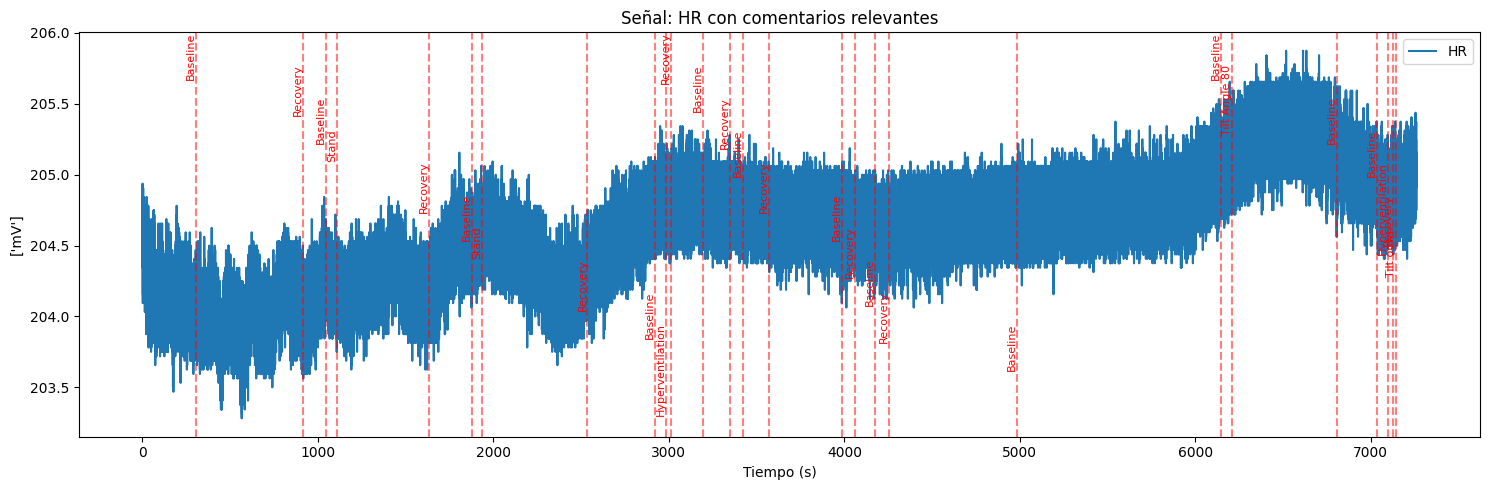

In [9]:
import matplotlib.pyplot as plt

# Obtener la señal y los comentarios
signal = prueba.Signal[1]
signal_data = signal.ProData
signal_time = signal.TimeSec
comments = signal.MarkerData

# Filtrar solo comentarios de coms o que contengan 'Tilt'
coms_lower = [c.lower() for c in coms]
filtered_comments = [
    c for c in comments
    if c.text and (
        any(com in c.text.lower() for com in coms_lower) or "tilt" in c.text.lower() or 'Baseline' in c.text or 'Recovery' in c.text
    )
]

plt.figure(figsize=(15, 5))
plt.plot(signal_time, signal_data, label=signal.Name)

# Graficar solo los comentarios filtrados
ymin, ymax = plt.ylim()
for idx, c in enumerate(filtered_comments):
    if c.time is not None and c.text:
        plt.axvline(x=c.time, color='red', linestyle='--', alpha=0.5)
        y_pos = ymax - (idx % 10) * (ymax - ymin) * 0.08
        plt.text(c.time, y_pos, c.text, rotation=90, color='red', va='top', ha='right', fontsize=8)

plt.title(f"Señal: {signal.Name} con comentarios relevantes")
plt.xlabel("Tiempo (s)")
plt.ylabel(signal.Units)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
for i in prueba.Signal[1].MarkerData:
    print(i.text)

NIBP: 126/78
Physio OFF
Baseline
Recovery
Baseline
Stand
NIBP: 125/87
NIBP: 132/83
Recovery
Physio ON
NIBP: 135/84
Physio OFF
Baseline
Stand
NIBP: 146/96
NIBP: 124/85
NIBP: 126/84
NIBP: 123/86
Recovery
NIBP: 138/82
Physio ON
NIBP: 131/82
Physio OFF
Baseline
Hyperventilation
Recovery
Physio ON
NIBP: 133/83
Physio OFF
Baseline
Sinus Arrhythmia
Recovery
Baseline
Sinus Arrhythmia
Recovery
Physio ON
NIBP: 133/94
Physio OFF
VAL IN 
Baseline
Valsalva
Recovery
Baseline
Valsalva
Recovery
VAL OUT
Physio ON
NIBP: 131/75
Physio OFF
Baseline
Baseline
Tilt Angle 80
NIBP: 122/93
NIBP: 130/89
NIBP: 121/82
Baseline
NIBP: 123/77
Baseline
Hyperventilation
Recovery
Tilt down
NIBP: 132/75


In [34]:
prueba.Signal[2].MarkerData[0]

EMSComment(text='NIBP: 126/78', tick_position=2215499, channel_=2, id=1, tick_dt=0.0001, time=221.5499)

In [18]:
f.channels[2].records[0]

          h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
         id: 1
    n_ticks: 669000
    tick_dt: 0.0001
   comments: []
record_time: Class::adi.read.RecordTime

In [7]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

from data.adicht_loader import load_adicht
from processing.ecg_analyzer import ECGAnalyzer
from core.signal import Signal

# Cambia esta ruta al archivo real que quieras probar
path = r"C:\Users\Poney\Desktop\Python\Aurora\uploaded_files\archivo_de_prueba.adicht"


# Cargar archivo
signal_group = load_adicht(path)

# Obtener señal ECG
ecg_signal = signal_group.get("ECG")

# Validación
if ecg_signal is None:
    raise ValueError("No se encontró señal ECG en el archivo.")

# Reconstruir señal completa
ecg_data, ecg_time = ecg_signal.get_full_signal(include_time=True)
fs = ecg_signal.fs

# Detectar picos R
peaks = ECGAnalyzer.detect_rr_peaks(ecg_data, fs)

# Crear HR_GEN (escalonada)
hr_data = []
hr_time = []

for i in range(1, len(peaks) - 1):
    idx_start = peaks[i]
    idx_end = peaks[i + 1]
    t_start = idx_start / fs
    t_end = idx_end / fs
    rr = t_end - t_start
    hr = 60 / rr if rr > 0 else 0
    hr_data.extend([hr, hr])
    hr_time.extend([t_start, t_end])

# Crear objeto Signal
hr_signal = Signal(name="HR_GEN", data=hr_data, time=hr_time, units="bpm", fs=1.0)

# Visualizar con Plotly
fig = go.Figure()

# ECG + picos
fig.add_trace(go.Scatter(x=ecg_time, y=ecg_data, name="ECG", line=dict(color="blue")))
fig.add_trace(go.Scatter(
    x=ecg_time[peaks],
    y=ecg_data[peaks],
    mode="markers",
    name="R-peaks",
    marker=dict(color="red", size=8)
))

# HR_GEN escalonada
fig.add_trace(go.Scatter(
    x=hr_signal.time,
    y=hr_signal.data,
    name="HR_GEN",
    line=dict(color="green", width=2, dash="dash")
))

fig.update_layout(
    title="ECG and HR_GEN Signal",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude / Heart Rate",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white",
    height=500
)

pio.renderers.default = "browser"
pio.show(fig)
